In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My Drive/kaggle/RSNA/content

/content/gdrive/My Drive/kaggle/RSNA/content


In [3]:
!ls

'GCP Credits Request Link - RSNA.txt'   stage_2_test_images
 image_bbox_full.csv		        stage_2_train_images
 overview.png			        stage_2_train_labels.csv
 stage_2_detailed_class_info.csv        train_segs.h5
 stage_2_sample_submission.csv


Overview
The notebook aims to get a better feeling for the data and more importantly the distributions of values. We take the labels and combine them with the detailed class info and try and determine what the biggest challenges of the prediction might be.

In [4]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug 

     |████████████████████████████████| 35.3MB 122kB/s 


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
from matplotlib.patches import Rectangle
det_class_path = '/content/gdrive/My Drive/kaggle/RSNA/content/stage_2_detailed_class_info.csv'
bbox_path = '/content/gdrive/My Drive/kaggle/RSNA/content/stage_2_train_labels.csv'
dicom_dir = '/content/gdrive/My Drive/kaggle/RSNA/content/stage_2_train_images'

Detailed Class Info

Here we show the image-level labels for the scans. The most interesting group here is the No Lung Opacity / Not Normal since they are cases that look like opacity but are not. So the first step might be to divide the test images into clear groups and then only perform the bounding box prediction on the suspicious images.

30227 class infos loaded
26684 patient cases


,patientId,class
15517,9791218b-e932-4580-a8eb-a835a596a338,No Lung Opacity / Not Normal
21054,bf10ff6e-fc24-4cfc-9b5f-7a156608dc1a,Lung Opacity
23532,d3f11cd9-12c4-464c-82fd-d43856533a77,Normal
27068,f0e63975-2990-4f7a-a9ea-8b2193acc83b,Normal
14880,9252b13b-8cbe-46b1-b294-73ace9047109,No Lung Opacity / Not Normal
8748,621d4f82-96c0-4189-9024-e1182f9d2d5f,No Lung Opacity / Not Normal
19251,b35a97b9-05a2-476e-8edc-356e2b228cde,No Lung Opacity / Not Normal
28286,fa7af4c7-4c35-48b6-bf91-585da33e4b6e,No Lung Opacity / Not Normal


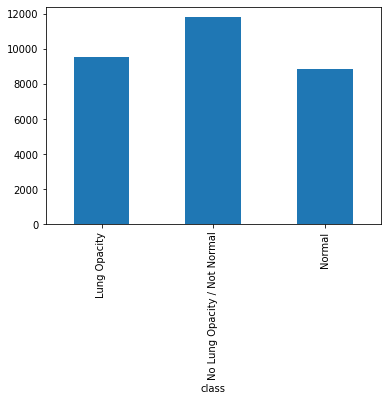

In [6]:
det_class_df = pd.read_csv(det_class_path)
print(det_class_df.shape[0], 'class infos loaded')
print(det_class_df['patientId'].value_counts().shape[0], 'patient cases')
det_class_df.groupby('class').size().plot.bar()
det_class_df.sample(8)

Load the Bounding Box Data

Here we show the bounding boxes

In [7]:
bbox_df = pd.read_csv(bbox_path)
print(bbox_df.shape[0], 'boxes loaded')
print(bbox_df['patientId'].value_counts().shape[0], 'patient cases')
bbox_df.sample(8)

30227 boxes loaded
26684 patient cases


,patientId,x,y,width,height,Target
28667,fd7b14ec-6ac4-4aa7-b9ff-de6930fc3af1,NaN,NaN,NaN,NaN,0
26261,ea872d0d-d42c-4330-9c09-799bc3b0ab09,NaN,NaN,NaN,NaN,0
12749,815dd1c1-3e01-4038-9723-39d05e8b3cd3,251.0,406.0,249.0,281.0,1
14569,8fb5ee99-8520-432a-a5e2-dea4789ec92f,NaN,NaN,NaN,NaN,0
28060,f8cf5335-860a-4248-8ee6-fa92dde76ab8,NaN,NaN,NaN,NaN,0
25218,e2108527-d2e6-4e06-afde-d3f321d008b9,NaN,NaN,NaN,NaN,0
6433,4ee60076-67b2-46f8-965e-29c167a30cd3,127.0,498.0,350.0,176.0,1
16850,a25056f9-2c4e-42f3-a035-26552647dcd4,273.0,155.0,172.0,209.0,1


Combine Boxes and Labels

Here we bring the labels and the boxes together and now we can focus on how the boxes look on the images

In [8]:
# we first try a join and see that it doesn't work (we end up with too many boxes)
comb_bbox_df = pd.merge(bbox_df, det_class_df, how='inner', on='patientId')
print(comb_bbox_df.shape[0], 'combined cases')

37629 combined cases


Concatenate

We have to concatenate the two datasets and then we get class and target information on each region

In [9]:
comb_bbox_df = pd.concat([bbox_df, 
                        det_class_df.drop('patientId',1)], 1)
print(comb_bbox_df.shape[0], 'combined cases')
comb_bbox_df.sample(8)

30227 combined cases


,patientId,x,y,width,height,Target,class
23320,d20338e0-8ae9-4a30-9a0e-8225aae32073,547.0,364.0,337.0,326.0,1,Lung Opacity
23948,d73509a6-c0c2-4c8a-8e41-4c58eecfc035,NaN,NaN,NaN,NaN,0,Normal
24367,daf303d1-d204-4dcd-a54d-c16d94a492d8,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
18478,ae432160-dfe3-4545-8cae-a9f5bae69b71,NaN,NaN,NaN,NaN,0,Normal
17299,a598d06c-3131-4bd6-a6c7-5a0cca114065,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2102,261341d3-1df2-4cf4-b9a8-b1e02a124900,594.0,362.0,123.0,167.0,1,Lung Opacity
14676,909e1bb8-f89e-472f-9b59-f2878ea7f928,NaN,NaN,NaN,NaN,0,Normal
17694,a8a1c87c-e541-48d6-981a-ac821dec99f0,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


Distribution of Boxes and Labels

The values below show the number of boxes and the patients that have that number.

In [10]:
box_df = comb_bbox_df.groupby('patientId')['x'].count().reset_index(name='boxes')
comb_box_df = pd.merge(comb_bbox_df, box_df, on='patientId')
box_df.\
    groupby('boxes').\
    size().\
    reset_index(name='patients')

,boxes,patients
0,0,20672
1,1,2614
2,2,3266
3,3,119
4,4,13


How are class and target related?

I assume that all the Target=1 values fall in the Lung Opacity class, but it doesn't hurt to check.

In [11]:
comb_bbox_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,9555
1,No Lung Opacity / Not Normal,0,11821
2,Normal,0,8851


Images

Now that we have the boxes and labels loaded we can examine a few images.

In [13]:
image_df = pd.DataFrame({'path': glob(os.path.join(dicom_dir, '*.dcm'))})
image_df['patientId'] = image_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print(image_df.shape[0], 'images found')
img_pat_ids = set(image_df['patientId'].values.tolist())
box_pat_ids = set(comb_box_df['patientId'].values.tolist())
# check to make sure there is no funny business
assert img_pat_ids.union(box_pat_ids)==img_pat_ids, "Patient IDs should be the same"

26684 images found


In [14]:
image_bbox_df = pd.merge(comb_box_df, 
                         image_df, 
                         on='patientId',
                        how='left').sort_values('patientId')
print(image_bbox_df.shape[0], 'image bounding boxes')
image_bbox_df.head(5)

30227 image bounding boxes


,patientId,x,y,width,height,Target,class,boxes,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,/content/gdrive/My Drive/kaggle/RSNA/content/s...
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal,0,/content/gdrive/My Drive/kaggle/RSNA/content/s...
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,2,/content/gdrive/My Drive/kaggle/RSNA/content/s...
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,2,/content/gdrive/My Drive/kaggle/RSNA/content/s...
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,2,/content/gdrive/My Drive/kaggle/RSNA/content/s...


Enrich the image fields

We have quite a bit of additional data in the DICOM header we can easily extract to help learn more about the patient like their age, view position and gender which can make the model much more precise

In [0]:
from scipy.ndimage import zoom
DCM_TAG_LIST = ['PatientAge', 'BodyPartExamined', 'ViewPosition', 'PatientSex']
def process_dicom(in_path, in_rows):
    c_dicom = pydicom.read_file(in_path, stop_before_pixels=False)
    tag_dict = {c_tag: getattr(c_dicom, c_tag, '') 
         for c_tag in DCM_TAG_LIST}
    tag_dict['path'] = in_path
    tag_dict['PatientAge'] = int(tag_dict['PatientAge'])
    tag_dict['boxes'] = in_rows.shape[0]
    tag_dict['class'] = in_rows['class'].iloc[0]
    return tag_dict, c_dicom.pixel_array
def create_seg_image(base_img, box_rows, out_shape = (512, 512)):
    c_size = base_img.shape
    x_fact = out_shape[0]/c_size[0]
    y_fact = out_shape[1]/c_size[1]
    rs_img = zoom(base_img, (x_fact, y_fact))
    mk_img = np.zeros(rs_img.shape, dtype=bool)
    x_vec = box_rows['x'].map(lambda x: x*x_fact).values.astype(int)
    y_vec = box_rows['y'].map(lambda y: y*y_fact).values.astype(int)
    w_vec = box_rows['width'].map(lambda w: w*x_fact).values.astype(int)
    h_vec = box_rows['height'].map(lambda h: h*y_fact).values.astype(int)
    for x, y, w, h in zip(x_vec,
                         y_vec, 
                         w_vec, 
                         h_vec):
        mk_img[y:(y+h), x:(x+w)] = True
    return rs_img, mk_img

{'PatientAge': 45, 'BodyPartExamined': 'CHEST', 'ViewPosition': 'PA', 'PatientSex': 'F', 'path': '/content/gdrive/My Drive/kaggle/RSNA/content/stage_2_train_images/0ab261f9-4eb5-42ab-a9a5-e918904d6356.dcm', 'boxes': 4, 'class': 'Lung Opacity'}


,patientId,x,y,width,height,Target,class,boxes,path
826,0ab261f9-4eb5-42ab-a9a5-e918904d6356,722.0,558.0,88.0,88.0,1,Lung Opacity,4,/content/gdrive/My Drive/kaggle/RSNA/content/s...
823,0ab261f9-4eb5-42ab-a9a5-e918904d6356,613.0,352.0,106.0,102.0,1,Lung Opacity,4,/content/gdrive/My Drive/kaggle/RSNA/content/s...
824,0ab261f9-4eb5-42ab-a9a5-e918904d6356,266.0,644.0,135.0,146.0,1,Lung Opacity,4,/content/gdrive/My Drive/kaggle/RSNA/content/s...
825,0ab261f9-4eb5-42ab-a9a5-e918904d6356,545.0,452.0,215.0,125.0,1,Lung Opacity,4,/content/gdrive/My Drive/kaggle/RSNA/content/s...


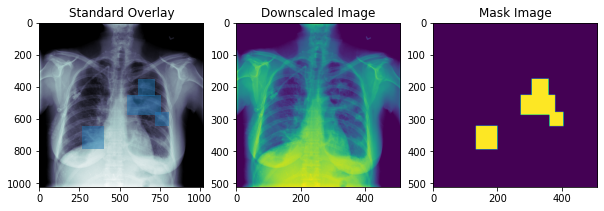

In [16]:
t_path, t_rows = next(iter(image_bbox_df.query('boxes>3').groupby(['path'])))
d_info, d_img = process_dicom(t_path, t_rows)
print(d_info)
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (10, 5))

ax0.imshow(d_img, cmap='bone')
ax0.set_title('Standard Overlay')
for _, c_row in t_rows.iterrows():
    ax0.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                 width=c_row['width'],
                 height=c_row['height'],
                           alpha=5e-1))

t_img, t_mask = create_seg_image(d_img, t_rows)
ax1.imshow(t_img)
ax1.set_title("Downscaled Image")
ax2.imshow(t_mask)
ax2.set_title('Mask Image')
t_rows

In [0]:
out_img_size = (512, 512)
keep_patients = 1000

In [0]:
balanced_patient_list = image_bbox_df.\
    query('Target==1')[['Target', 'path']].\
    drop_duplicates().\
    groupby('Target').\
    apply(lambda x: x.sample(keep_patients, random_state=2018, replace=True)).\
    reset_index(drop=True)['path'].values
np.random.seed(2018)
all_groups = list(image_bbox_df[image_bbox_df['path'].isin(balanced_patient_list)].groupby(['path']))
keep_idx = np.random.choice(range(len(all_groups)), keep_patients)
all_groups = [all_groups[i] for i in keep_idx]

In [19]:
import h5py
from tqdm import tqdm_notebook

with h5py.File('train_segs.h5', 'w') as f:
    image_out = f.create_dataset('image', 
                                 shape=(len(all_groups), out_img_size[0], out_img_size[1], 1),
                                 dtype=np.uint8)
    mask_out = f.create_dataset('mask', 
                                 shape=(len(all_groups), out_img_size[0], out_img_size[1], 1),
                                 dtype=bool,
                                 compression='gzip')
    d_info, _ = process_dicom(t_path, t_rows)
    
    key_ds_out = {}
    for k,v in d_info.items():
        if isinstance(v, str):
            key_ds_out[k] = f.create_dataset(k, 
                                 shape=(len(all_groups),),
                                 dtype='S{}'.format(len(v)+2))
        elif isinstance(v, int):
            key_ds_out[k] = f.create_dataset(k, 
                                 shape=(len(all_groups),),
                                 dtype=int)
        else:
            print('Unsupported key-type {}: {}'.format(type(v), v))
    for i, (c_path, c_rows) in enumerate(tqdm_notebook(all_groups)):
        c_info, c_raw_img = process_dicom(c_path, c_rows)
        c_img, c_mask = create_seg_image(c_raw_img, c_rows, out_shape=out_img_size)
        image_out[i, :, :, 0] = c_img
        mask_out[i, :, :, 0] = c_mask
        for k in key_ds_out.keys():
            if k in c_info:
                if isinstance(c_info[k], str):
                    key_ds_out[k][i] = c_info[k].encode('ascii')
                else:
                    key_ds_out[k][i] = c_info[k]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [20]:
!ls -lh *.h5
with h5py.File('train_segs.h5', 'r') as f:
    for k in f.keys():
        print(k, f[k].shape, f[k].dtype)
        print(k, f[k][0])

-rw------- 1 root root 252M Apr 12 18:19 train_segs.h5
BodyPartExamined (1000,) |S7
BodyPartExamined b'CHEST'
PatientAge (1000,) int64
PatientAge 43
PatientSex (1000,) |S3
PatientSex b'M'
ViewPosition (1000,) |S4
ViewPosition b'AP'
boxes (1000,) int64
boxes 2
class (1000,) |S14
class b'Lung Opacity'
image (1000, 512, 512, 1) uint8
image [[[  0]
  [  0]
  [  0]
  ...
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  ...
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  ...
  [  0]
  [  0]
  [  0]]

 ...

 [[ 16]
  [ 32]
  [ 34]
  ...
  [213]
  [208]
  [122]]

 [[ 14]
  [ 29]
  [ 33]
  ...
  [208]
  [212]
  [120]]

 [[  7]
  [ 14]
  [ 15]
  ...
  [105]
  [ 98]
  [ 58]]]
mask (1000, 512, 512, 1) bool
mask [[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[Fal